1. Подгрузим необходимые билиотеки и загрузим данные по йене

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Load the dataset using pandas
# data = pd.read_csv("JPY.csv") 

data = pd.read_csv("JPY.csv", parse_dates=["Date"], index_col=["Date"])
data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-10-30,114.370003,114.480003,113.610001,114.180000,114.180000,0.0
1996-10-31,NaN,NaN,NaN,NaN,NaN,NaN
1996-11-01,113.500000,113.500000,113.500000,113.500000,113.500000,0.0
1996-11-04,113.279999,113.980003,112.949997,113.879997,113.879997,0.0
1996-11-05,113.709999,114.330002,113.449997,114.250000,114.250000,0.0


In [111]:
# Будем работать только с данными закрытия дня "Close"
data = data[["Close"]] # select Date and Price
# Rename the features: These names are NEEDED for the model fitting
# data = data.rename(columns = {"Date":"ds","Close":"y"}) #renaming the columns of the dataset
data.head(5)

,Close
Date,
1996-10-30,114.180000
1996-10-31,NaN
1996-11-01,113.500000
1996-11-04,113.879997
1996-11-05,114.250000


In [112]:
# Проверим данные на пропущенные значения
data.isna().sum()

Close    43
dtype: int64

2. Визуализируем данные

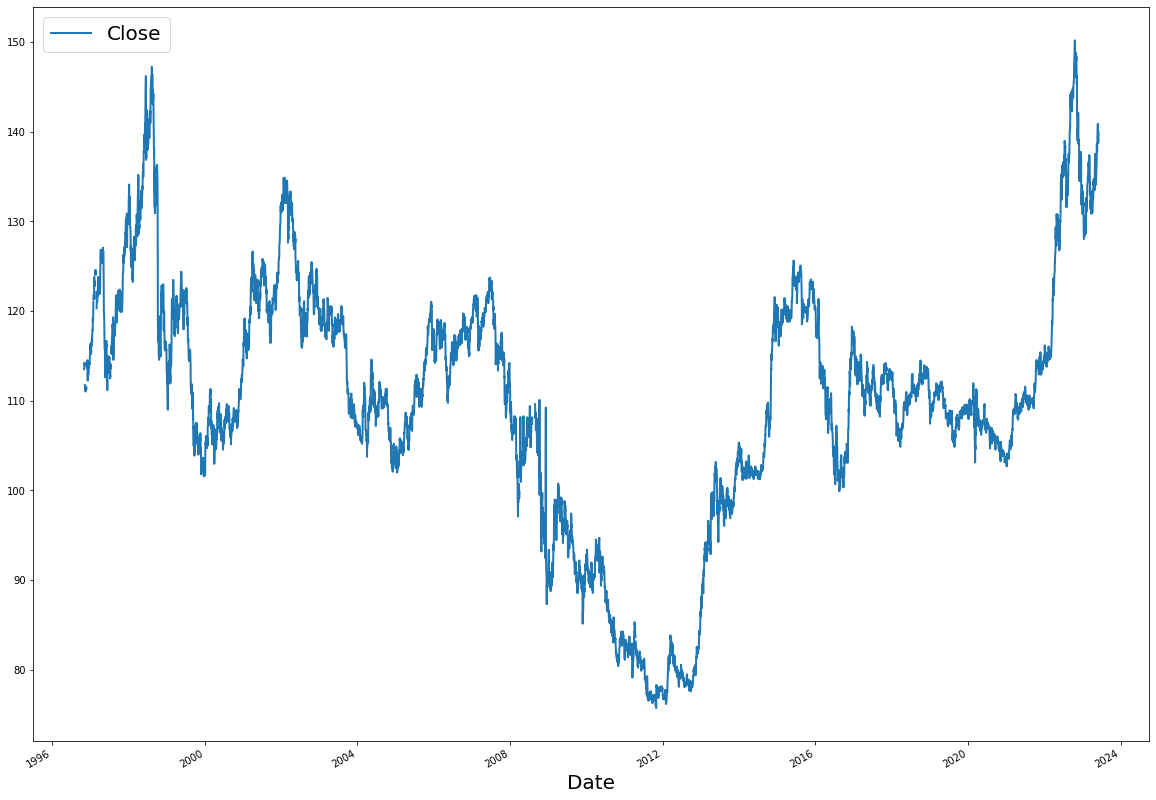

In [113]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.rcParams["figure.figsize"] = 20, 15
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 2

data.plot()
plt.show()

 3. Также видим что есть пропуске в данных и для заполнения пропусков выполните интерполяцию с использованием метода .interpolate()

In [114]:
data[["Close"]] = data[["Close"]].interpolate(method='linear')

4. Посмотрим распределения данных по годам.

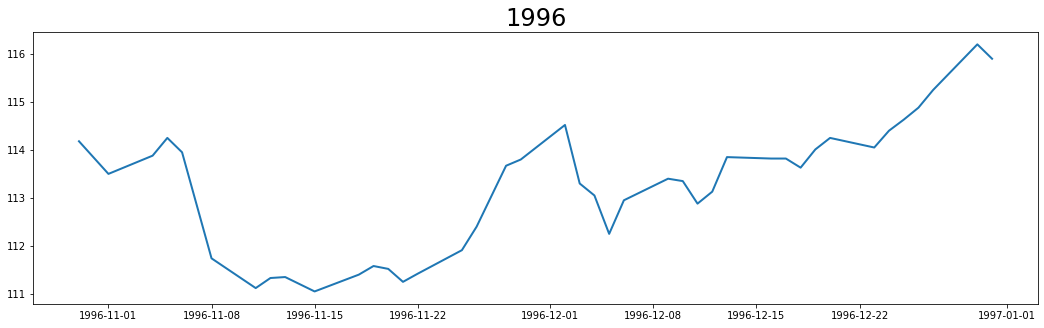

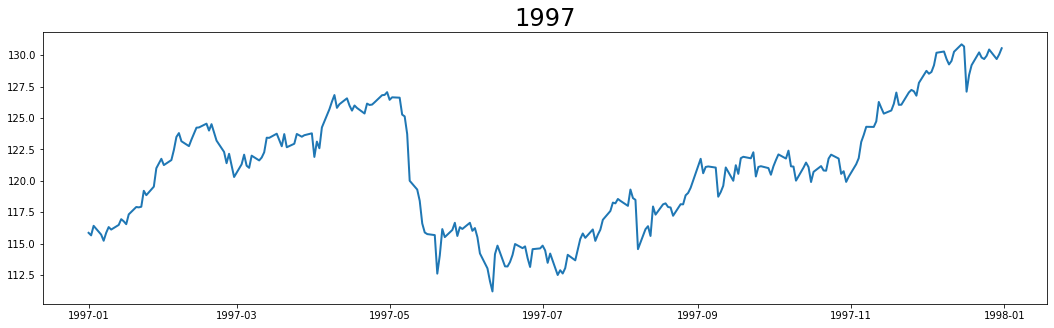

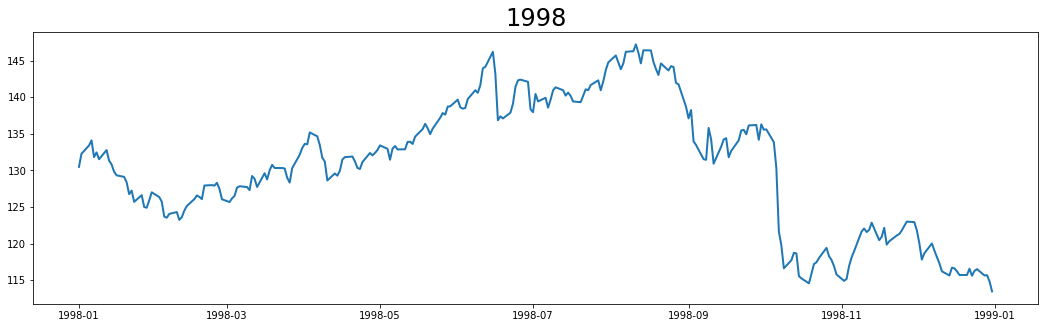

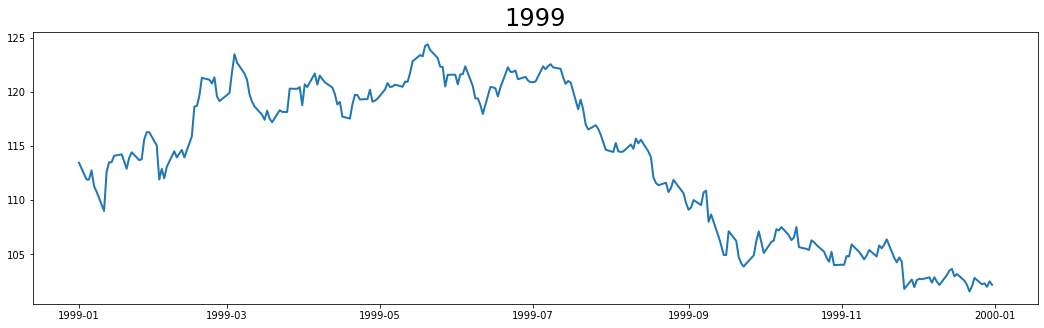

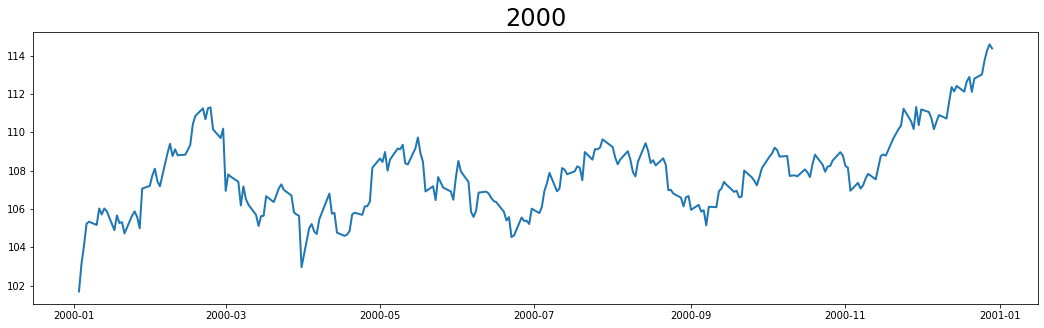

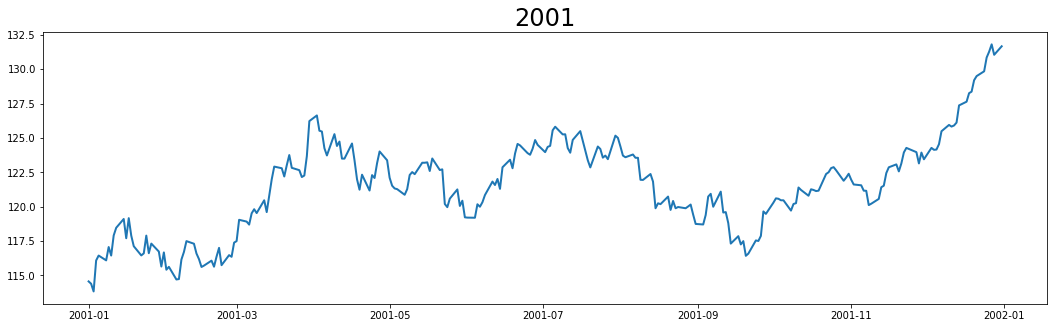

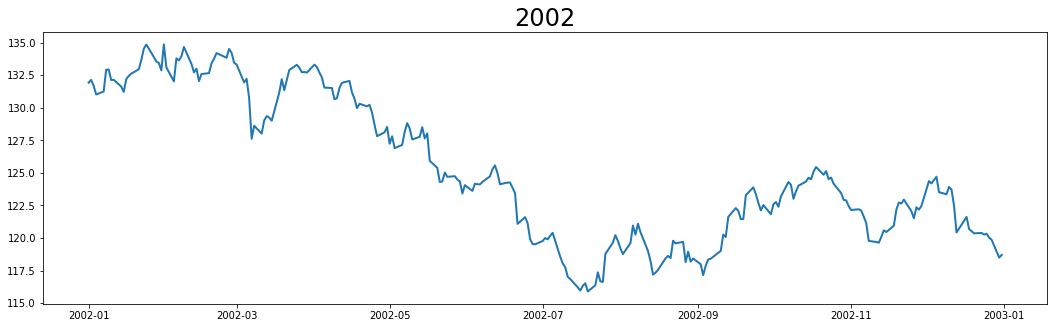

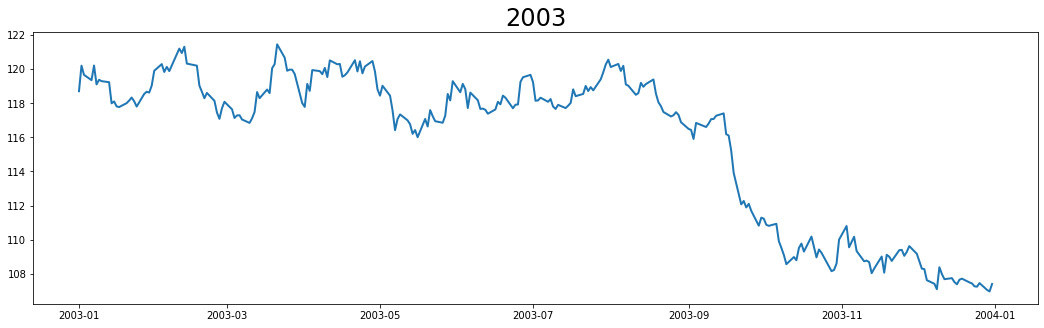

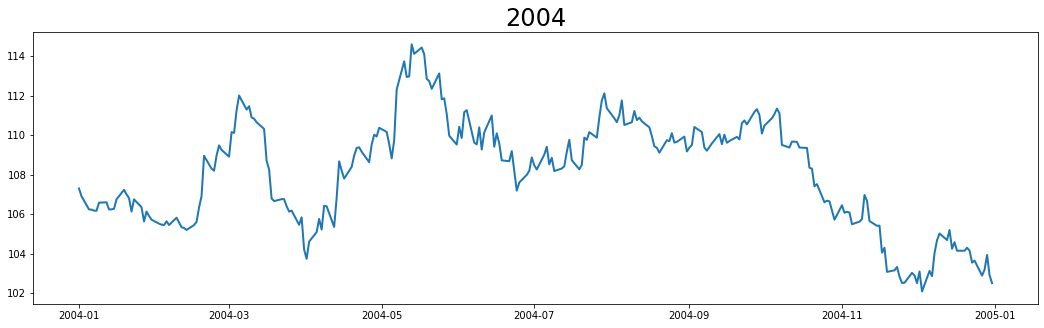

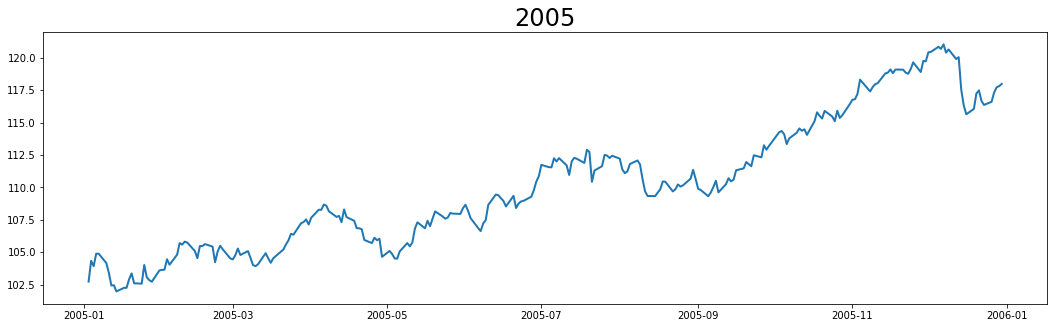

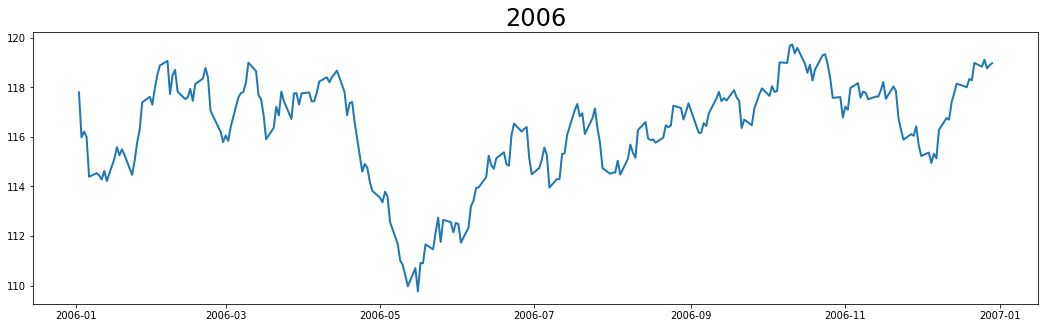

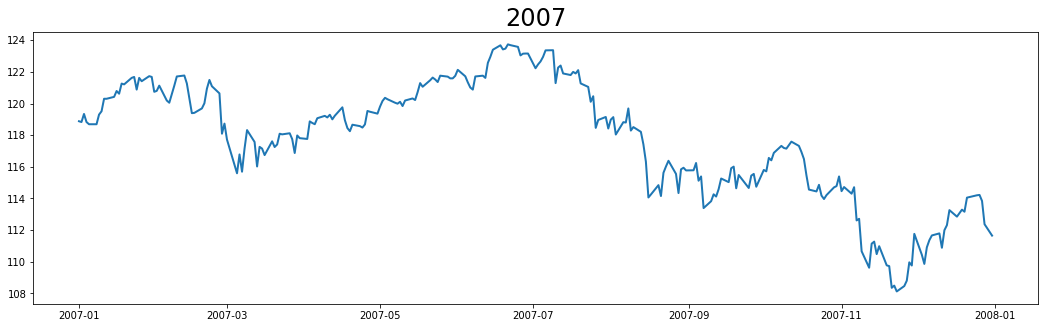

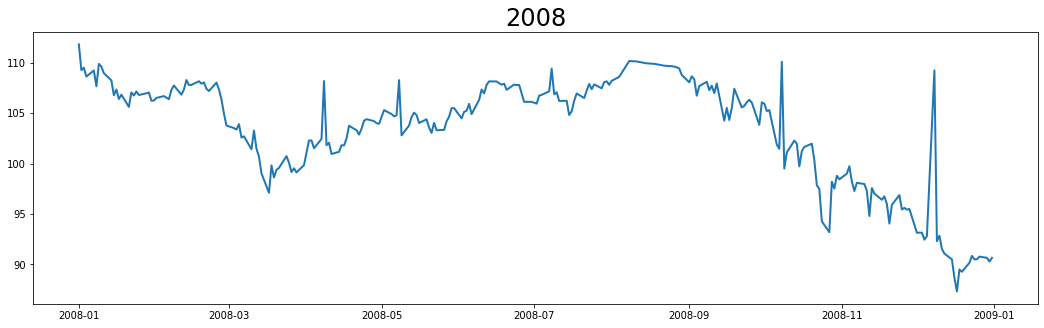

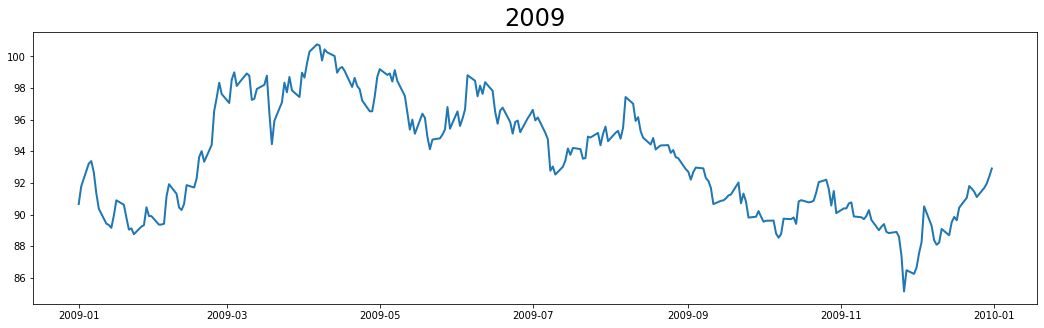

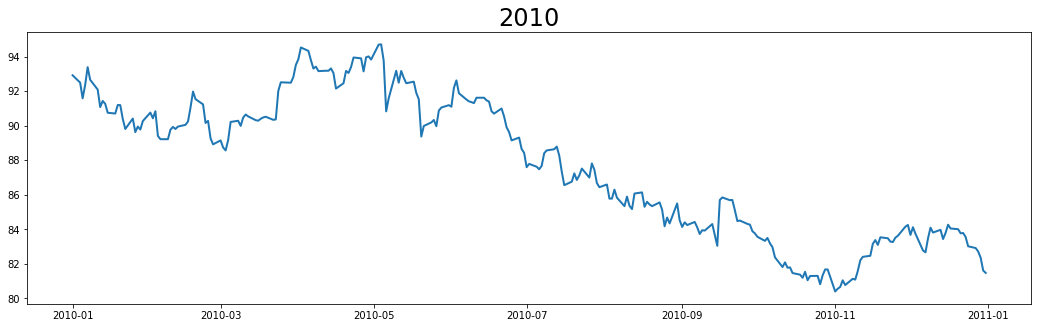

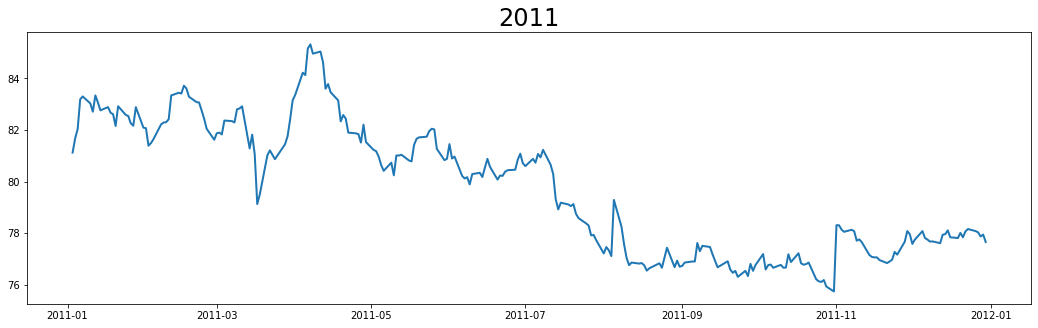

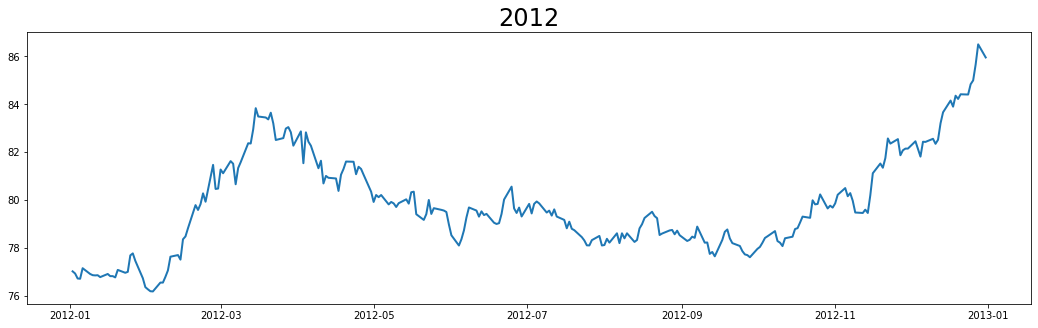

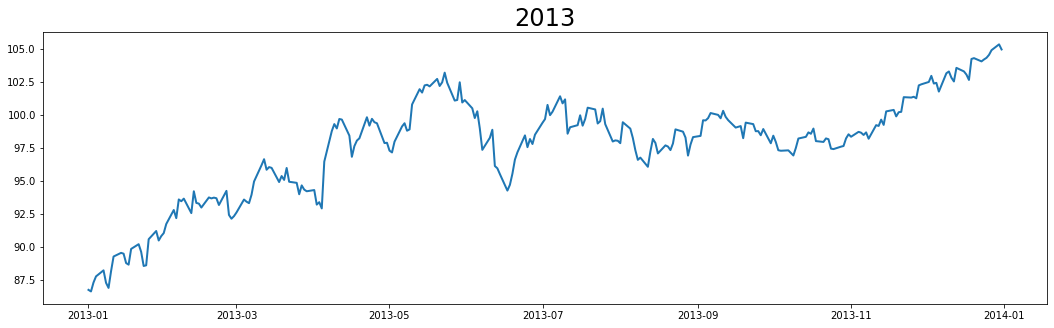

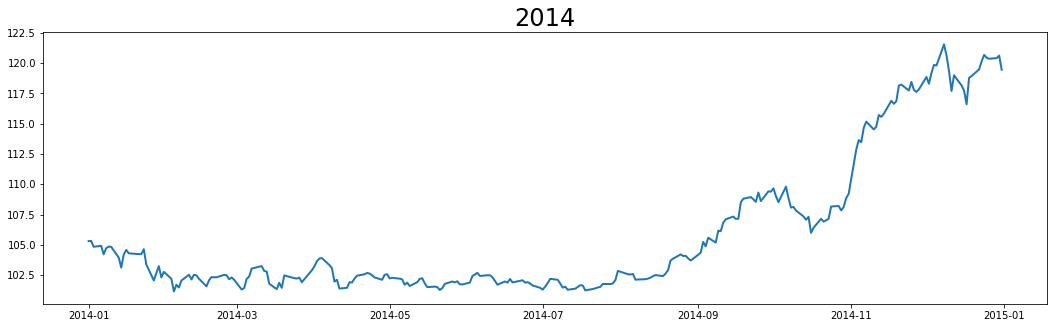

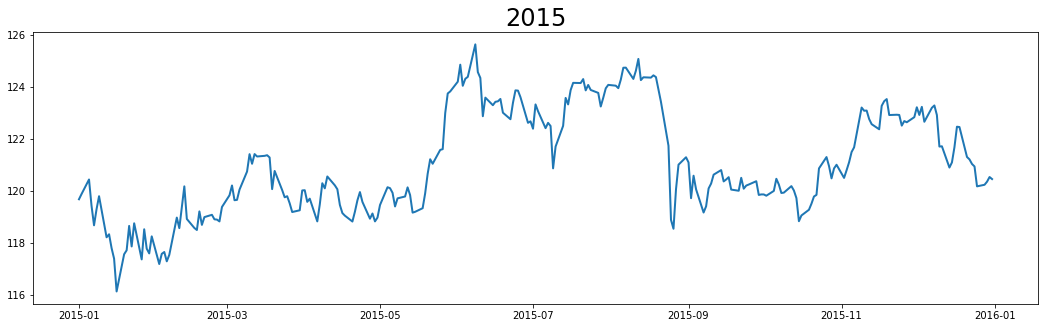

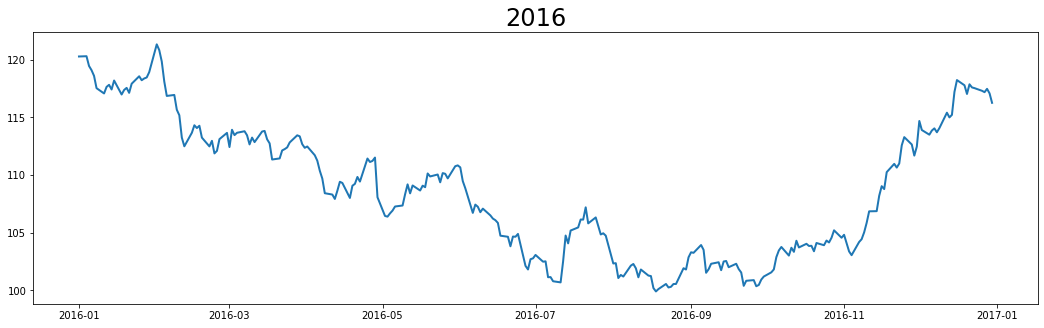

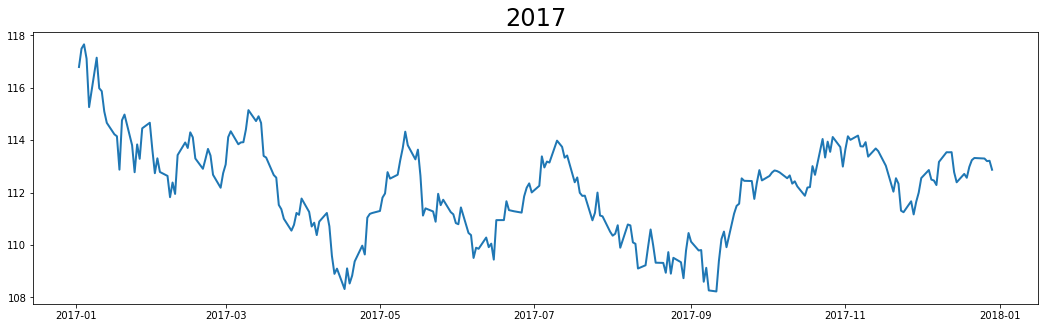

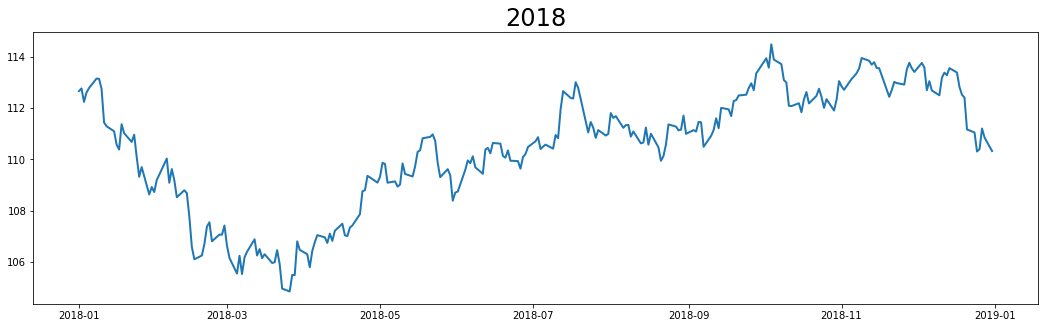

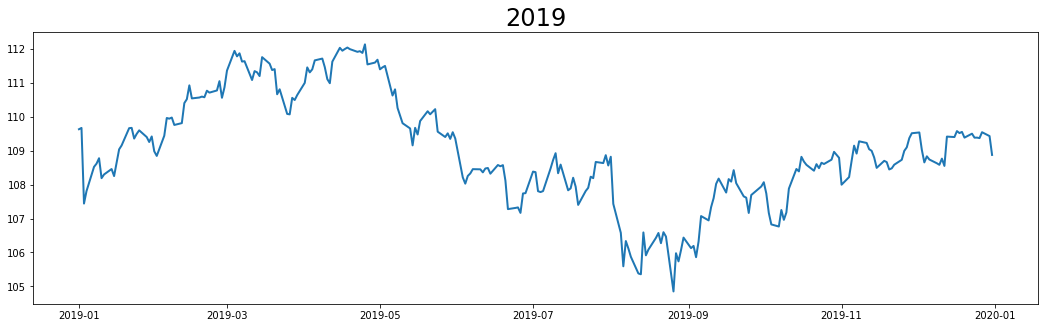

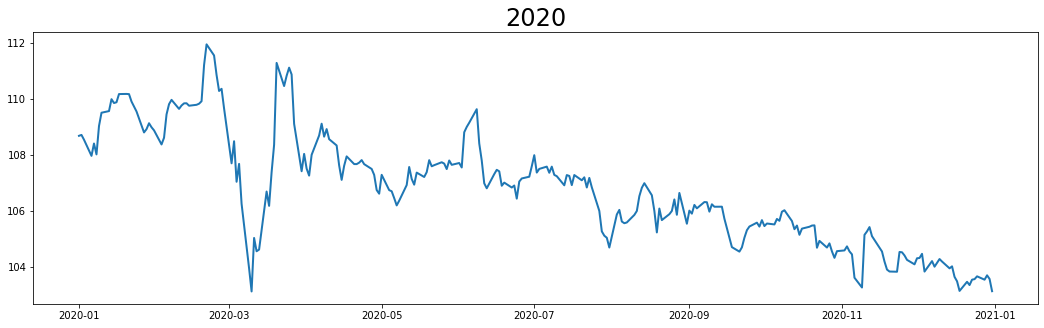

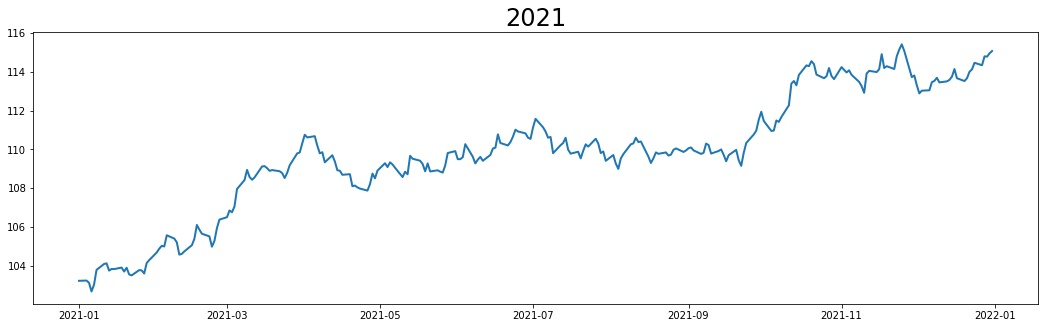

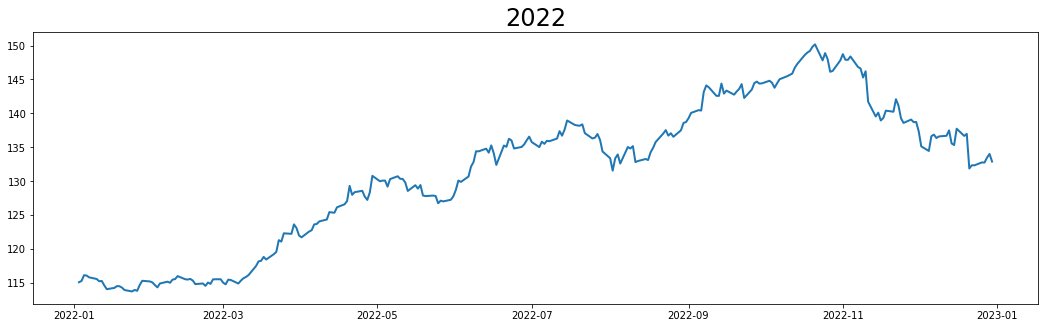

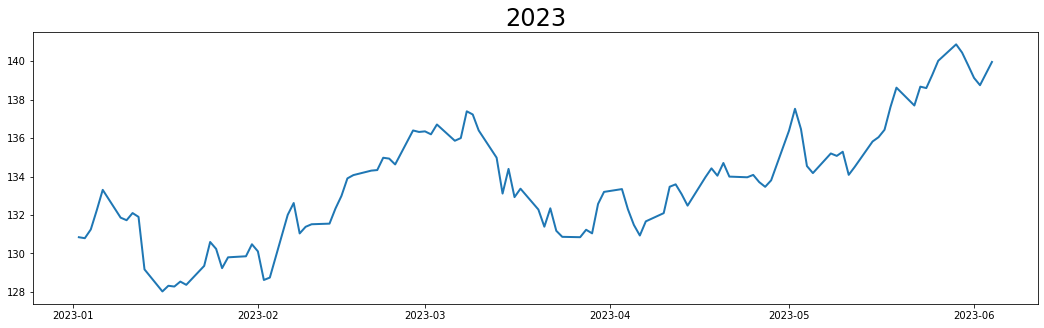

In [115]:
# Проверим как распределены данные
plt.rcParams["figure.figsize"] = 18, 5

for year in set(data.index.year):
    plt.plot(data[["Close"]].loc[data.index.year == year])
    plt.title(str(year), size=24)
    plt.show()

Поведение данны в разные года разное и очевидно что данные не ведут собя одинаково из года в год.

5. Разделим данные на тренировачные и тестовые

In [116]:
train_df = data.loc[:"2022-12-31"]
test_df = data.loc["2023-01-01":]
train_df.shape, test_df.shape

((6828, 1), (111, 1))

6. Перейдем к самому анализу. Сделаем сезонную декомпозицию ряда.

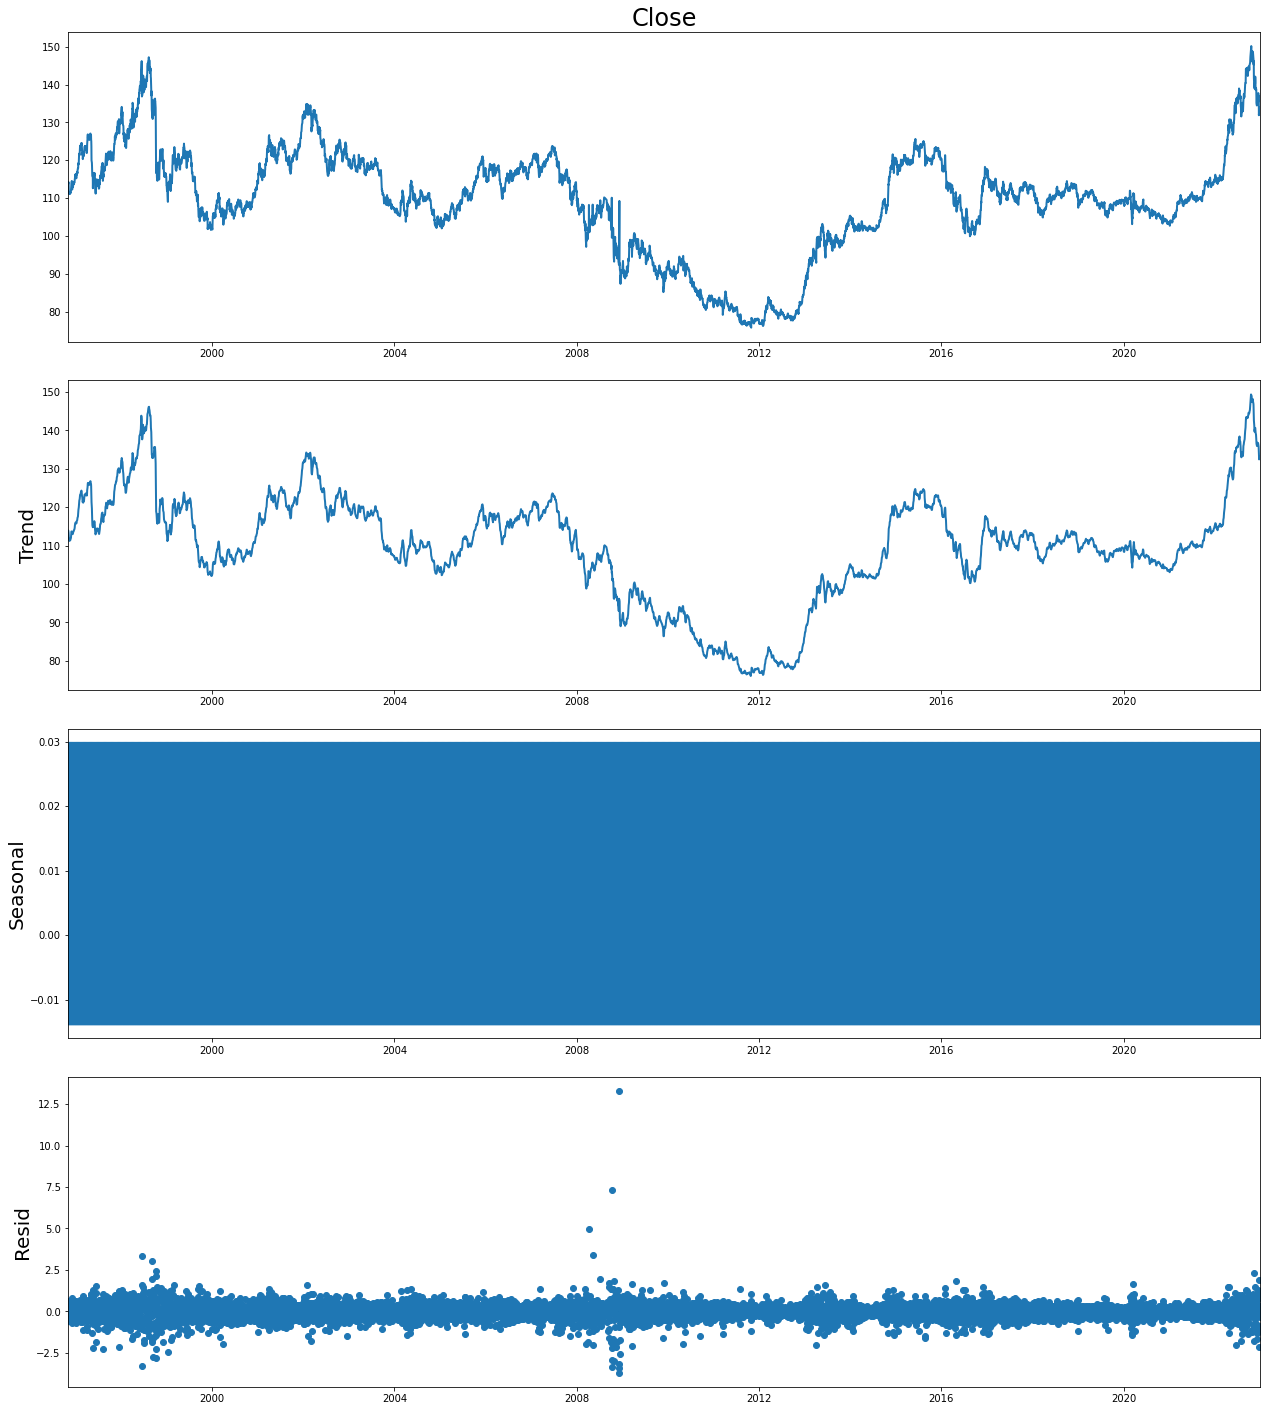

In [117]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df.Close)
result.plot()
plt.show()

7. Сезонная компонента выглядит очень странно, посмотрим на первые 20 значений

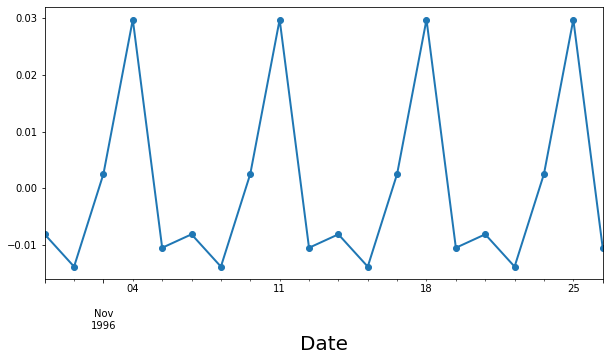

In [118]:
plt.rcParams["figure.figsize"] = 10, 5
result.seasonal[:20].plot(marker="o")
plt.show()

График четко показывает повторяющийся цикл каждые 5 периодов. Это довольно логично, поскольку наши данные — это данные о ценах на валюту. Мы наблюдаем и собираем данные о ценах на валюту каждый рабочий день недели. Это означает, что данные представляли собой еженедельную сезонность, а неделя была рабочей неделей (5 дней в неделю)

8. Построим скользящие среднии с окном 30 дней и 300 дней

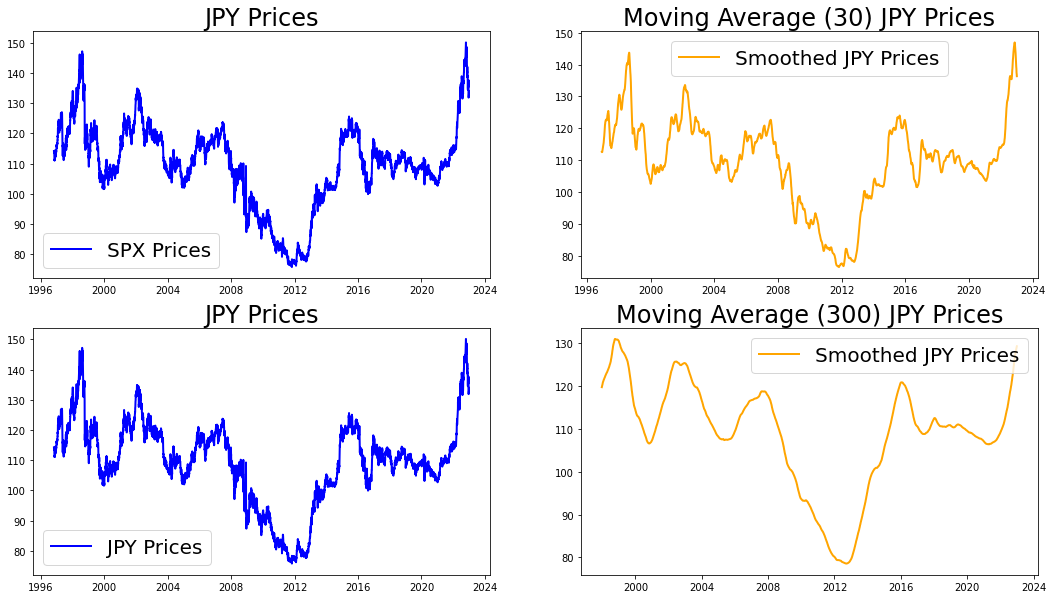

In [119]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

# Окно в месяц (Window = 30)
ax[0, 0].plot(train_df.Close, color="blue", label="SPX Prices")
ax[0, 0].set_title("JPY Prices", size=24)
ax[0, 0].legend()

ax[0, 1].plot(train_df.Close.rolling(window=30).mean(),color="orange",label="Smoothed JPY Prices",)

ax[0, 1].set_title("Moving Average (30) JPY Prices", size=24)
ax[0, 1].legend()


# Окно в год (Window = 300)
ax[1, 0].plot(train_df.Close, color="blue", label="JPY Prices")
ax[1, 0].set_title("JPY Prices", size=24)
ax[1, 0].legend()

ax[1, 1].plot(train_df.Close.rolling(window=300).mean(),color="orange",label="Smoothed JPY Prices",)

ax[1, 1].set_title("Moving Average (300) JPY Prices", size=24)
ax[1, 1].legend()

plt.show()

8. Построим коррелограмму для нашего временного ряда

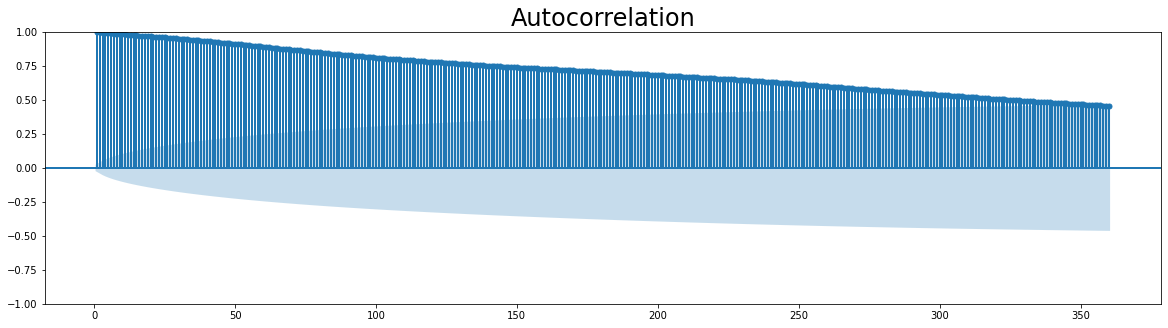

In [120]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df.Close, lags=360, zero=False)
plt.show()

Цены JPY сильно коррелированы. Корреляция сохраняется даже по прошествии года.

9. Построим график частичной корреляции

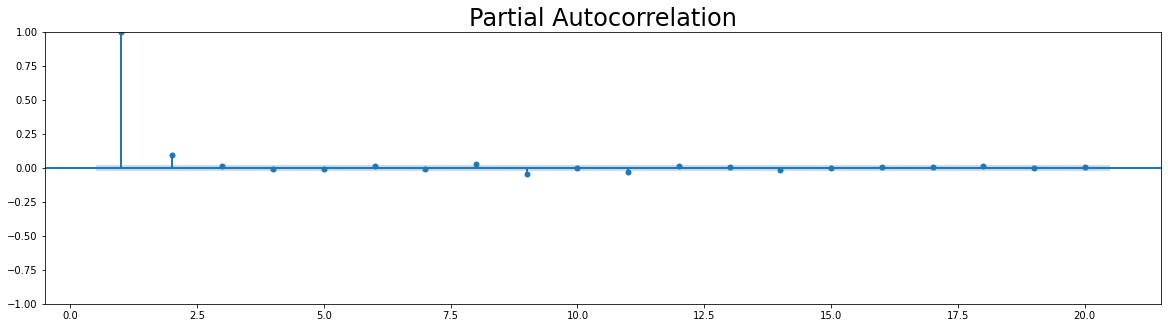

In [121]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df.Close, lags=20, method="ywm", zero=False)
plt.show()

Эти графики показывают, как данные коррелируют с запаздывающей версией самих себя. В отличие от того, что предлагали графики ACF, цены JPY с лагом не приносят никакой новой информации. В таких ситуация параметр p выбирается =1

10. Проведем тест Дики-Фуллера на стационарность ряда

In [122]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_df["Close"])

(-1.965274597657093,
 0.30200338381098235,
 35,
 6792,
 {'1%': -3.431313158592296,
  '5%': -2.8619656366679043,
  '10%': -2.566996562658244},
 16270.656307903695)

In [123]:
test1 = adfuller(train_df["Close"])
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  -1.965274597657093
p-value:  0.30200338381098235
Critical values:  {'1%': -3.431313158592296, '5%': -2.8619656366679043, '10%': -2.566996562658244}
ряд нестационарен


Статистика теста больше всех критических значений, поэтому нулевую гипотезу ($H_0$) нельзя отвергнуть.

Поэтому цены *JPY* не являются стационарными

11. Нам необходимо избавиться от нестационарности нашего временного ряда

## Дифференцирование ряда
$y\_new_t = y_t - y_{t-1}$

where, 
- $y\_new_t$: Дифференцированное значение ряда $t$
- $y_t$: Фактическое значение ряда $t$
- $y_{t-1}$: Фактическое значение ряда $t-1$

In [124]:
# Функция построения коррелограмм
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=40)
    sgt.plot_pacf(series, ax=axes[1], lags=40, method="ywm")
    plt.show()

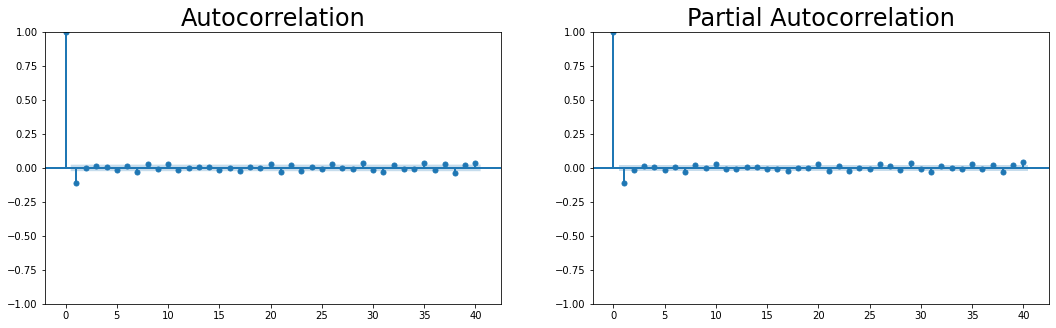

(-13.31021091952104,
 6.770238614546905e-25,
 34,
 6792,
 {'1%': -3.431313158592296,
  '5%': -2.8619656366679043,
  '10%': -2.566996562658244},
 16270.90679148409)

In [45]:
plot_acf_pacf(train_df["Close"].diff().dropna())
adfuller(train_df["Close"].diff().dropna())

Первые разности являются стационарными. Так как значение в тесте Дики-Фуллера меньше всех критических значений разного уровня значимости.

12. Перейдем к построению моделей

#### ARIMA, SARIMA

Начнем построение модели **ARIMA** со следующими параметрами:

- p = 1 
- d = 1 
- q = 1 

Если рассматривать сезонную модель (**SARMA**), то в модель можно добавить следующие параметры.

- m = 5 (будучи рыночным индексом, данные, скорее всего, будут иметь еженедельно повторяющиеся паттерны, как видно из визуализации)
- P = 1 
- D = 1
- Q = 1 

In [125]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df["Close"].dropna(), order=(1, 1, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\programdata\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\programdata\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\programdata\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 6828
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -8167.722
Date:                Mon, 12 Jun 2023   AIC                          16341.444
Time:                        19:27:01   BIC                          16361.930
Sample:                    10-30-1996   HQIC                         16348.512
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0022      0.068      0.032      0.975      -0.130       0.134
ma.L1         -0.1155      0.068     -1.710      0.087      -0.248       0.017
sigma2         0.6407      0.002    259.674      0.000       0.636       0.646
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            862666.00
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        58.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Второй столбец раздела I содержит некоторые полезные показатели, которые используются для сравнения различных моделей ARIMA. Как правило, модель с более высоким логарифмическим правдоподобием или более низким IC (AIC, BIC или HQIC) лучше, и наоборот.

In [126]:
seas_model = SARIMAX(
    train_df["Close"].dropna(), order=(1, 1, 2), seasonal_order=(1, 1, 2, 5)
)

seas_model_fit = seas_model.fit()
seas_model_fit.summary()

c:\programdata\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\programdata\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\programdata\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\programdata\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                 6828
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 5)   Log Likelihood               -8175.241
Date:                           Mon, 12 Jun 2023   AIC                          16364.482
Time:                                   19:27:14   BIC                          16412.277
Sample:                               10-30-1996   HQIC                         16380.972
                                    - 12-30-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1473      3.305     -0.045      0.964      -6.625       6.330
ma.L1          0.0349      3.306      0.011      0.992      -6.444       6.514
ma.L2         -0.0193      0.372     -0.052      0.959      -0.748       0.710
ar.S.L5       -0.7346      0.141     -5.225      0.000      -1.010      -0.459
ma.S.L5       -0.2863      0.145     -1.977      0.048      -0.570      -0.003
ma.S.L10      -0.7104      0.145     -4.905      0.000      -0.994      -0.427
sigma2         0.6407      0.003    188.295      0.000       0.634       0.647
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            840787.32
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        57.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

13. Создадим предсказание

In [127]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = seas_model_fit.predict(start=test_df.index[0], end=test_df.index[-1])

pred_df["Close"] = data["Close"]

forecast = seas_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower Close"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper Close"]

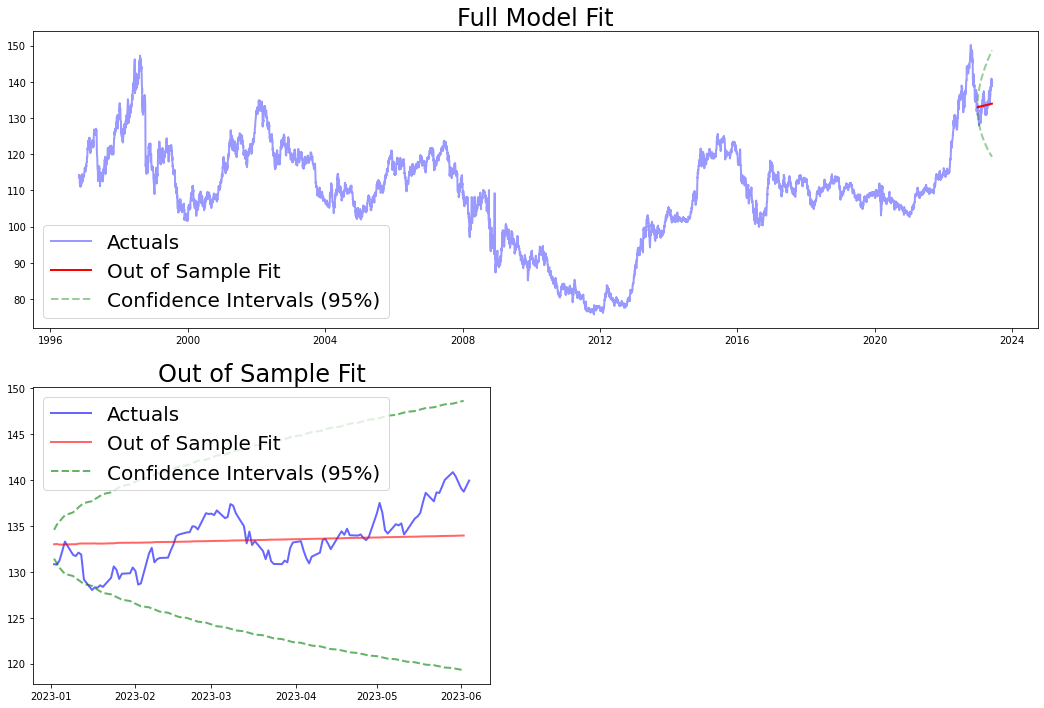

In [128]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["Close"], color="blue", label="Actuals", alpha=0.4)

plt.plot(pred_df.loc[test_df.index]["model_preds"], color="red", linestyle="-",label="Out of Sample Fit",)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"],color="green",linestyle="--",label="Confidence Intervals (95%)",alpha=0.4,)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"],color="green",linestyle="--",alpha=0.4,)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(pred_df.loc[test_df.index]["Close"], color="blue", label="Actuals", alpha=0.6)

plt.plot(pred_df.loc[test_df.index]["model_preds"],color="red",linestyle="-",label="Out of Sample Fit",alpha=0.6,)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"],color="green",linestyle="--",label="Confidence Intervals (95%)",alpha=0.6,)

plt.plot(pred_df.loc[test_df.index]["model_preds_upper"],color="green",linestyle="--",alpha=0.6,)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

14. Воспользуемся пакетом **pmdarima** и подберем оптимальные значения

In [129]:
import pmdarima as pm

smodel = pm.auto_arima(
    train_df["Close"],
    start_p=0,start_q=0,d=0,
    start_P=0,max_p=3,max_q=3,D=1,
    m=5,seasonal=True,
    test="adf",
    error_action="ignore",
    trace=True,stepwise=True
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[5] intercept   : AIC=26118.927, Time=0.62 sec
 ARIMA(0,0,0)(0,1,0)[5] intercept   : AIC=26123.788, Time=0.24 sec
 ARIMA(1,0,0)(1,1,0)[5] intercept   : AIC=18571.593, Time=1.21 sec
 ARIMA(0,0,1)(0,1,1)[5] intercept   : AIC=22450.350, Time=0.92 sec
 ARIMA(0,0,0)(0,1,0)[5]             : AIC=26122.293, Time=0.22 sec
 ARIMA(1,0,0)(0,1,0)[5] intercept   : AIC=20363.226, Time=0.37 sec
 ARIMA(1,0,0)(2,1,0)[5] intercept   : AIC=18000.208, Time=2.05 sec
 ARIMA(1,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=6.71 sec
 ARIMA(1,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=5.36 sec
 ARIMA(0,0,0)(2,1,0)[5] intercept   : AIC=26115.676, Time=0.82 sec
 ARIMA(2,0,0)(2,1,0)[5] intercept   : AIC=17978.130, Time=3.30 sec
 ARIMA(2,0,0)(1,1,0)[5] intercept   : AIC=18562.875, Time=1.47 sec
 ARIMA(2,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=9.52 sec
 ARIMA(2,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=6.21 sec
 ARIMA(3,0,0)(2,1,0)[5] intercept   : AIC=1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 6828
Model:             SARIMAX(3, 0, 1)x(2, 1, [], 5)   Log Likelihood               -8971.756
Date:                            Mon, 12 Jun 2023   AIC                          17957.511
Time:                                    19:30:23   BIC                          18005.307
Sample:                                10-30-1996   HQIC                         17974.002
                                     - 12-30-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0795      0.021     -3.819      0.000      -0.120      -0.039
ar.L2          0.8499      0.015     56.518      0.000       0.820       0.879
ar.L3          0.0295      0.008      3.868      0.000       0.015       0.044
ma.L1          0.9225      0.020     46.113      0.000       0.883       0.962
ar.S.L5       -0.6438      0.007    -91.841      0.000      -0.657      -0.630
ar.S.L10      -0.3030      0.005    -55.497      0.000      -0.314      -0.292
sigma2         0.8118      0.004    195.282      0.000       0.804       0.820
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            359327.99
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

14. Наилучшие значения получены ARIMA(3,0,1)(2,1,0)[5] Сделаем предсказание на этих данных

In [130]:
seas_model = SARIMAX(train_df["Close"].dropna(), order=(3, 0, 1), seasonal_order=(2, 1, 0, 5))

seas_model_fit = seas_model.fit()
seas_model_fit.summary()

c:\programdata\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
c:\programdata\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                 6828
Model:             SARIMAX(3, 0, 1)x(2, 1, [], 5)   Log Likelihood               -8971.756
Date:                            Mon, 12 Jun 2023   AIC                          17957.511
Time:                                    19:31:30   BIC                          18005.307
Sample:                                10-30-1996   HQIC                         17974.002
                                     - 12-30-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0795      0.021     -3.819      0.000      -0.120      -0.039
ar.L2          0.8499      0.015     56.518      0.000       0.820       0.879
ar.L3          0.0295      0.008      3.868      0.000       0.015       0.044
ma.L1          0.9225      0.020     46.113      0.000       0.883       0.962
ar.S.L5       -0.6438      0.007    -91.841      0.000      -0.657      -0.630
ar.S.L10      -0.3030      0.005    -55.497      0.000      -0.314      -0.292
sigma2         0.8118      0.004    195.282      0.000       0.804       0.820
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            359327.99
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

15. Построим предсказания на полученных значениях

In [131]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = seas_model_fit.predict(start=test_df.index[0], end=test_df.index[-1])

pred_df["Close"] = data["Close"]

forecast = seas_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower Close"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper Close"]

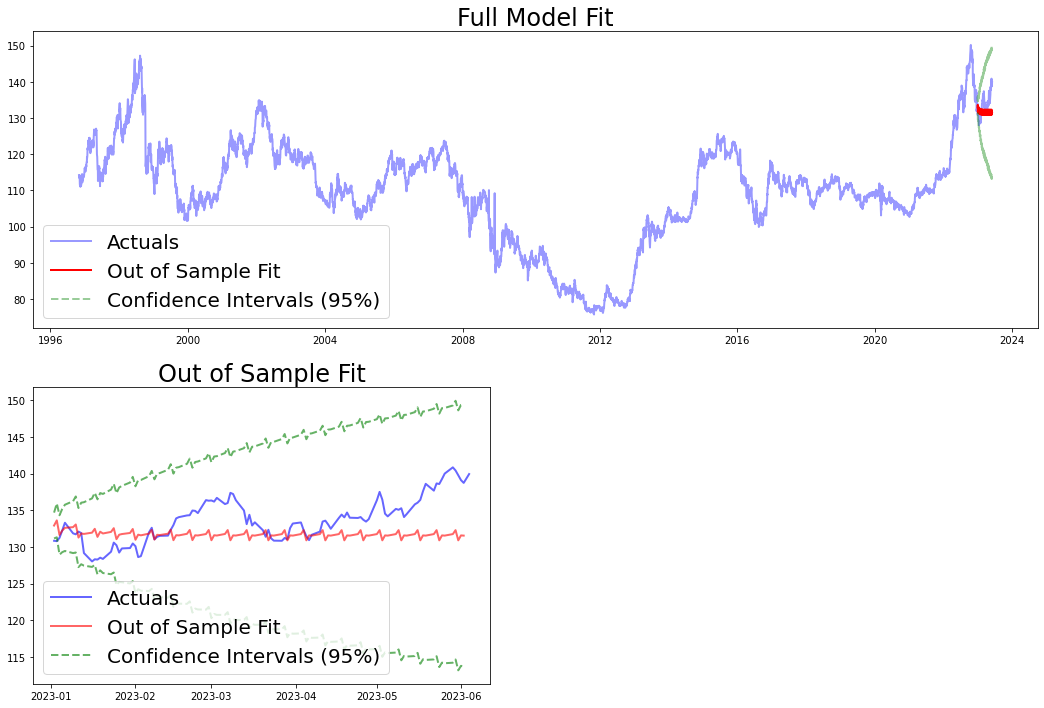

In [132]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["Close"], color="blue", label="Actuals", alpha=0.4)

plt.plot(pred_df.loc[test_df.index]["model_preds"], color="red", linestyle="-",label="Out of Sample Fit",)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"],color="green",linestyle="--",label="Confidence Intervals (95%)",alpha=0.4,)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"],color="green",linestyle="--",alpha=0.4,)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(pred_df.loc[test_df.index]["Close"], color="blue", label="Actuals", alpha=0.6)

plt.plot(pred_df.loc[test_df.index]["model_preds"],color="red",linestyle="-",label="Out of Sample Fit",alpha=0.6,)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"],color="green",linestyle="--",label="Confidence Intervals (95%)",alpha=0.6,)

plt.plot(pred_df.loc[test_df.index]["model_preds_upper"],color="green",linestyle="--",alpha=0.6,)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

Фактические значения попадают в доверительный предсказанный интервал.